In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

In [39]:
##with open('bgg_df.pickle', 'rb') as f:
##    df = pickle.load(f)

In [40]:
##with open('rec_df.pickle', 'rb') as f2:
##    rec_df = pickle.load(f2)

# Initial Data Exploration

In [3]:
df.head()

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
0,Troia,None,2005.0,2,2,60,60,60,8,"[Card Game, Math, Mythology]",...,0.0,3,0,0,0,102580,0.50000,0,0.00,0.0000
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,None,2009.0,2,4,25,25,25,6,"[Animals, Children's Game, Movies / TV / Radio...",...,0.0,25,1,0,0,102595,1.29363,0,0.00,-0.3400
2,Quintessential: The Fifth Element,None,2011.0,2,5,45,45,45,13,[Dice],...,0.0,28,1,2,15,102597,1.74950,4,2.75,0.9983
3,Wort für Wort,None,1998.0,1,5,25,25,25,6,"[Children's Game, Educational, Word Game]",...,0.0,25,2,0,1,102598,1.36677,0,0.00,0.4939
4,Hannah Montana Secret Star,None,2009.0,2,4,15,15,15,6,"[Movies / TV / Radio theme, Racing]",...,0.0,7,0,0,1,102599,1.00000,0,0.00,0.0000


In [6]:
df.shape

(100088, 29)

In [38]:
df.columns

Index(['name', 'desc', 'yr_pub', 'min_players', 'max_players', 'avg_play_time',
       'min_play_time', 'max_play_time', 'min_age', 'categories', 'mechanics',
       'families', 'has_expansion', 'designers', 'artists', 'publishers',
       'comments', 'bgtype', 'num_users_rated', 'avg_user_rating',
       'bgg_adj_rating', 'owned', 'trading', 'wanting', 'wishing', 'game_id',
       'stddev', 'num_users_complexity', 'complexity', 'avg_sentiment_score'],
      dtype='object')

In [6]:
#Discoved that description column was not obtained during scrape
df[df['desc'].isna()]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
0,Troia,None,2005.0,2,2,60,60,60,8,"[Card Game, Math, Mythology]",...,5.50000,0.0,3,0,0,0,102580,0.500000,0,0.00
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,None,2009.0,2,4,25,25,25,6,"[Animals, Children's Game, Movies / TV / Radio...",...,5.42857,0.0,25,1,0,0,102595,1.293630,0,0.00
2,Quintessential: The Fifth Element,None,2011.0,2,5,45,45,45,13,[Dice],...,7.54167,0.0,28,1,2,15,102597,1.749500,4,2.75
3,Wort für Wort,None,1998.0,1,5,25,25,25,6,"[Children's Game, Educational, Word Game]",...,5.08333,0.0,25,2,0,1,102598,1.366770,0,0.00
4,Hannah Montana Secret Star,None,2009.0,2,4,15,15,15,6,"[Movies / TV / Radio theme, Racing]",...,4.00000,0.0,7,0,0,1,102599,1.000000,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100083,All My Ducks,None,1997.0,2,4,5,5,5,6,"[Animals, Children's Game, Memory]",...,5.00000,0.0,6,1,0,1,15346,0.816497,0,0.00
100084,Frosty The Snowman,None,1979.0,2,4,20,20,20,4,"[Children's Game, Movies / TV / Radio theme, R...",...,4.62500,0.0,8,0,0,0,15347,0.414578,0,0.00
100085,Furby Adventure Game,None,1999.0,2,6,15,15,15,4,[Children's Game],...,3.75000,0.0,10,2,0,1,15348,0.559017,2,3.00
100086,Caboose Dice,None,1974.0,2,2,30,30,30,12,[Trains],...,2.50000,0.0,4,1,1,3,15349,0.000000,0,0.00


In [7]:
#Found N/A years and decided to use the min minus the current range to group the missing/inputted years together
#but not have as large a distance from the instances with years.
df[df['yr_pub']!=0]['yr_pub'].min()

1680.0

In [8]:
df['yr_pub'].max()

2023.0

In [41]:
df['yr_pub'].fillna(1337,inplace=True)
df['yr_pub'].replace(0,1337,inplace=True)

In [17]:
df[df['yr_pub'].isna()]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
14501,Clash of the Princes,None,NaN,0,0,0,0,0,0,"[Exploration, Fantasy, Fighting]",...,0.0,52,3,2,4,54165,1.13578,3,2.0,0.9904
41677,Showdown,None,NaN,0,0,0,0,0,0,[American West],...,0.0,48,0,2,6,57161,1.62895,4,3.5,0.9913


In [57]:
df[df['yr_pub']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score


In [9]:
#check outliers
df['min_players'].value_counts()

2     72660
1     14046
3      8205
4      2469
0      1837
6       243
5       224
8       219
7        64
10       44
12       22
9        21
15        7
20        5
11        4
13        4
16        4
14        3
40        2
18        1
22        1
24        1
25        1
50        1
Name: min_players, dtype: int64

In [12]:
#check outliers
sorted(df['max_players'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 47,
 48,
 50,
 51,
 52,
 54,
 55,
 56,
 60,
 61,
 64,
 68,
 69,
 72,
 75,
 76,
 80,
 81,
 88,
 90,
 92,
 96,
 98,
 99,
 100,
 101,
 102,
 103,
 112,
 120,
 125,
 127,
 150,
 160,
 163,
 190,
 200,
 250,
 362,
 399,
 400,
 420,
 500,
 600,
 900,
 999,
 1000,
 2000,
 10000,
 11299]

In [13]:
#focus on avg. or min?
df['avg_play_time'].value_counts()

0        22225
30       15846
60       11182
20        9195
45        6992
         ...  
38           1
165          1
10080        1
72000        1
72           1
Name: avg_play_time, Length: 177, dtype: int64

In [14]:
df.sort_values('avg_play_time',ascending=False)

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
15678,Office Space: The Game,None,2020.0,2,10,30000000,30,30000000,16,"[Movies / TV / Radio theme, Party Game]",...,3.90000,0.00000,22,1,0,6,311320,0.000000,0,0.0
15524,Ars Combinatoria,None,2017.0,2,8,1576800,10,1576800,0,"[Card Game, Party Game]",...,6.16667,0.00000,32,4,1,6,234010,0.687184,0,0.0
58568,再会の約束 (Saikai no Yakusoku),None,2017.0,2,4,1576800,157680,1576800,8,"[Card Game, Educational, Party Game]",...,3.00000,0.00000,2,1,0,0,229870,0.000000,0,0.0
64806,Vietnam: 1965-1975,None,2021.0,2,2,525600,4,525600,12,"[Vietnam War, Wargame]",...,10.00000,0.00000,1,0,2,20,332402,0.000000,2,3.5
5849,"Death Ride Kursk: Sud-Front, Russland Staff Li...",None,2018.0,6,20,100000,1000,100000,16,[Wargame],...,0.00000,0.00000,1,0,0,0,331152,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56332,Tic-Tac Bingo Game,None,0.0,2,4,0,0,0,3,"[Abstract Strategy, Children's Game, Dice, Rea...",...,4.00000,0.00000,0,0,0,0,114870,1.000000,0,0.0
56336,The Hobbit: An Unexpected Journey,None,2012.0,2,6,0,0,0,6,"[Fantasy, Movies / TV / Radio theme, Novel-based]",...,2.63181,5.43586,65,5,1,4,135801,1.581000,4,1.0
56337,Lalaloopsy: Tea Party Game,None,2012.0,2,4,0,0,0,5,[],...,7.00000,0.00000,0,0,0,0,135802,3.000000,0,0.0
56341,Don't Get Mad,None,2012.0,2,6,0,0,0,8,"[Party Game, Puzzle, Trivia]",...,5.87500,0.00000,6,3,0,0,135807,0.125000,0,0.0


In [15]:
df['min_play_time'].value_counts()

0        21015
30       17250
20       10616
60        9901
15        9189
         ...  
33           1
225          1
2400         1
10080        1
62           1
Name: min_play_time, Length: 126, dtype: int64

In [16]:
df['max_play_time'].value_counts()

0        22225
30       15846
60       11182
20        9195
45        6992
         ...  
38           1
165          1
10080        1
72000        1
72           1
Name: max_play_time, Length: 177, dtype: int64

In [17]:
#avg. = 9.420796
df['min_age'].value_counts()

0       22062
8       17480
12      15234
10      12582
6        6470
14       4485
7        4351
5        3968
4        3133
13       3011
3        1829
9        1534
18       1207
16        931
15        708
11        385
17        314
2         199
21        132
20         22
1          16
30         10
19          6
36          4
60          3
25          2
45          2
50          2
24          1
2017        1
22          1
40          1
112         1
90          1
Name: min_age, dtype: int64

In [19]:
df[df['min_age']!=0].mean()

desc                            NaN
yr_pub                  1851.255094
min_players                2.028862
max_players                6.411619
avg_play_time            473.850793
min_play_time             45.619037
max_play_time            473.850793
min_age                    9.420796
has_expansion              0.083088
num_users_rated          223.190821
avg_user_rating            4.702506
bgg_adj_rating             1.416223
owned                    377.606490
trading                   11.734230
wanting                   11.580102
wishing                   60.702497
game_id                         inf
stddev                     0.941893
num_users_complexity      13.470766
complexity                 0.903338
avg_sentiment_score        0.437044
dtype: float64

In [18]:
df[df['avg_play_time']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,avg_user_rating,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity
52,Bulyah,None,2000.0,2,6,0,0,0,0,"[Humor, Party Game]",...,0.00000,0.0,0,0,0,0,23856,0.000000,0,0.0000
53,Epées Royales,None,2006.0,2,2,0,0,0,12,"[Medieval, Wargame]",...,7.22222,0.0,55,0,6,6,23857,1.157370,7,2.1429
54,Batman,None,1976.0,2,4,0,0,0,0,[Comic Book / Strip],...,4.00000,0.0,7,0,0,4,23858,2.943920,0,0.0000
55,"Murder à la carte: Eat, Drink, and Be Married",None,1997.0,6,8,0,0,0,18,"[Deduction, Murder/Mystery, Party Game]",...,0.00000,0.0,26,6,3,2,23859,0.000000,0,0.0000
57,Kort Alfapet,None,1996.0,2,4,0,0,0,0,"[Card Game, Word Game]",...,6.00000,0.0,15,0,2,4,23861,0.866025,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100048,Supporters,None,1990.0,2,2,0,0,0,12,[Sports],...,3.50000,0.0,17,0,0,1,15306,1.500000,0,0.0000
100052,HotFlash! The Menopause Game,None,2003.0,2,8,0,0,0,18,"[Educational, Humor]",...,1.00000,0.0,3,0,1,1,15310,0.000000,0,0.0000
100055,Duckula Card Game,None,1989.0,2,4,0,0,0,0,[Movies / TV / Radio theme],...,5.33333,0.0,4,0,1,2,15314,1.247220,0,0.0000
100060,Astrology: The Game of Prediction,None,1972.0,2,10,0,0,0,10,"[Educational, Party Game]",...,4.33333,0.0,11,1,3,5,15321,4.027680,1,2.0000


# Sentiment Analysis

In [32]:
#Since some comments were non-English, attempted to focus on analyzing English comments, but did not like the loss
#from this attempt at finding only English comments.
words = set(nltk.corpus.words.words())
df['eng_comments'] = np.empty((len(df), 0)).tolist()
for idx, commlist in enumerate(df['comments']):
    eng_list = []
    for comment in commlist:
        eng_comment = " ".join(w for w in nltk.wordpunct_tokenize(comment) if w.lower() in words or not w.isalpha())
        eng_list.append(eng_comment)
    df.at[idx,'eng_comments'] = eng_list

In [36]:
df.iloc[1]['comments']

['06.02.04.01',
 '06.02.04.01 identische Neuauflage 2015 ((c)2015 + Art. Nr. Position anders)',
 'Okay with kids\nUnfortunately it uses too many stereotypes.',
 'for Kids between 6 and 13 years',
 'Kinderspiel\n']

In [37]:
df.iloc[1]['eng_comments']

['06 . 02 . 04 . 01',
 '06 . 02 . 04 . 01 2015 (( c ) 2015 + Art . . Position )',
 'with Unfortunately it too many .',
 'for between 6 and 13',
 '']

In [72]:
##with open('bgg_df.pickle', 'wb') as bgg_df_pickle:
##    pickle.dump(df, bgg_df_pickle)

In [71]:
#Initial attempt of sentiment analysis was done with all comments as one

##df['avg_sentiment_score'] = 0.0
##for idx, row in enumerate(df['comments']):
##    analyser = SentimentIntensityAnalyzer()
##    vscore = analyser.polarity_scores(row)
##    comscore = vscore.get('compound')
##    df.at[idx,'avg_sentiment_score'] = float(comscore)

In [15]:
sent_scores = []
for idx, row in enumerate(df['comments']):
    game_sent = []
    for col in row:
        analyser = SentimentIntensityAnalyzer()
        vscore = analyser.polarity_scores(col)
        comscore = vscore.get('compound')
        game_sent.append(comscore)
    sent_scores.append(game_sent)

In [17]:
##with open('sent_scores_list.pickle', 'wb') as sent_scores_pickle:
##    pickle.dump(sent_scores, sent_scores_pickle)

In [4]:
##with open('sent_scores_list.pickle', 'rb') as f:
##    sent_scores = pickle.load(f)

In [10]:
avg_sent_score_list = []
for score in sent_scores:
    try:
        avg_sent_score_list.append(sum(score)/len(score))
    except:
        avg_sent_score_list.append(0)

In [5]:
#Performed to see how many of 0 sentiment scores were from above games with no comments.
for score in sent_scores:
    try:
        avg_sent_score_list2.append(sum(score)/len(score))
    except:
        continue

In [30]:
#Performed to group games with no comments together, but separate from games with comments
avg_sent_score_list3 = []
for score in sent_scores:
    try:
        avg_sent_score_list3.append(sum(score)/len(score))
    except:
        avg_sent_score_list3.append(3)

In [37]:
count = 0
for item in avg_sent_score_list:
    if item == 0:
        count += 1
print(count)

43246


In [7]:
#Just under 32000 games without comments
count = 0
for item in avg_sent_score_list2:
    if item == 0:
        count += 1
print(count)

11077


In [18]:
avg_sent_df = pd.DataFrame(avg_sent_score_list,columns=['avg_sent_score'])

In [4]:
df['avg_sentiment_score'].value_counts()

 0.0000    44128
 0.9999     4203
 1.0000     2827
 0.9998     1690
 0.9997     1044
           ...  
-0.2341        1
 0.4105        1
 0.3326        1
-0.8541        1
 0.5730        1
Name: avg_sentiment_score, Length: 7738, dtype: int64

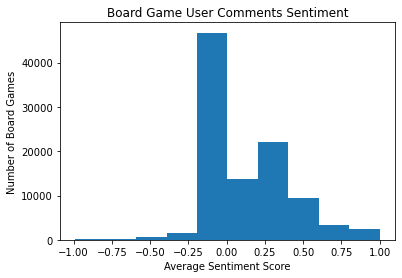

In [27]:
#First plot with no comment games mixed in
#plt.hist(avg_sent_score_list)
#plt.xlabel('Average Sentiment Score')
#plt.ylabel('Number of Board Games')
#plt.title('Board Game User Comments Sentiment');

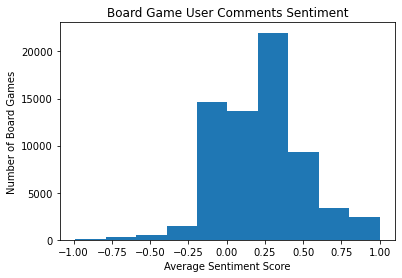

In [6]:
plt.hist(avg_sent_score_list2)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Number of Board Games')
plt.title('Board Game User Comments Sentiment')
plt.savefig('sentiment_hist.svg');

In [31]:
avgss = pd.DataFrame(avg_sent_score_list3,columns=['avg_sent_score'])

In [71]:
avgss[avgss['avg_sent_score']==0]

,avg_sent_score
4,0.0
63,0.0
71,0.0
147,0.0
152,0.0
...,...
100051,0.0
100056,0.0
100066,0.0
100069,0.0


# Adding On Standardized Numercial and Binarized Categorical Columns

In [25]:
#,'designers','artists','publishers'
cat_columns = ['categories','mechanics','families']
num_columns = ['yr_pub','min_players','max_players','avg_play_time','min_play_time','max_play_time','min_age','complexity','avg_user_rating']

In [26]:
#Adding in column for topic modeling "user types"
ut_cols = ['components','quickplay','dice_game','party_game','thematic','kickstarter', \
           'new_versions','deckbuilding', 'scorekeeping','kids','wargame','other']

In [60]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ut_ohe = ohe.fit_transform(rec_df['user_type'].values.reshape(-1,1))
ut_df = pd.DataFrame(ut_ohe,columns=ut_cols)

In [61]:
ut_df

,components,quickplay,dice_game,party_game,thematic,kickstarter,new_versions,deckbuilding,scorekeeping,kids,wargame,other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
100083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100084,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
cat_mlb_list = []
class_list = []
for col in cat_columns:
    mlb = MultiLabelBinarizer()
    df_mlb = mlb.fit_transform(df[col])
    mlbdf = pd.DataFrame(df_mlb,columns=mlb.classes_)
    cat_mlb_list.append(mlbdf)
    class_list.append(mlb.classes_)

In [43]:
from sklearn.preprocessing import StandardScaler
num_ss_list = []
for col in num_columns:
    scalar = StandardScaler()
    df_ss = scalar.fit_transform(df[col].values.reshape(-1,1))
    ssdf = pd.DataFrame(df_ss,columns=['scaled_'+str(col)])
    num_ss_list.append(ssdf)

In [44]:
num_df = pd.concat(num_ss_list,axis=1)

In [28]:
num_df.head()

,scaled_yr_pub,scaled_min_players,scaled_max_players,scaled_avg_play_time,scaled_min_play_time,scaled_max_play_time,scaled_min_age,scaled_complexity,scaled_avg_user_rating
0,0.325022,0.000258,-0.083245,-0.003503,0.031223,-0.003503,0.081888,-0.756420,0.357393
1,0.331922,0.000258,-0.044188,-0.003871,-0.029224,-0.003871,-0.167849,-0.756420,0.333452
2,0.335372,0.000258,-0.024659,-0.003661,0.005317,-0.003661,0.706231,1.731186,1.041689
3,0.312948,-1.173922,-0.024659,-0.003871,-0.029224,-0.003871,-0.167849,-0.756420,0.217740
4,0.331922,0.000258,-0.044188,-0.003976,-0.046495,-0.003976,-0.167849,-0.756420,-0.145354


In [12]:
cat_df = pd.concat(cat_mlb_list,axis=1)

In [13]:
cat_df.head()

,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,...,Video Game Theme: SEGA,Video Game Theme: Sonic the Hedgehog,Video Game Theme: Super Mario Bros.,Video Game Theme: Tetris,Webcomics: Dork Tower,Webcomics: Penny Arcade,Word Games: First Letter Given,Word Games: Guess the Word,Word Games: Sign Language,Word Games: Spelling / Letters
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#details = df[['name','avg_sentiment_score','url']+num_columns]
details = df[['avg_user_rating','has_expansion']]

In [24]:
details.head()

,name,avg_sentiment_score,url,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,complexity
0,Troia,0.0000,https://boardgamegeek.com/boardgame/102580,2005.0,2,2,60,60,60,8,0.00
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,-0.3400,https://boardgamegeek.com/boardgame/102595,2009.0,2,4,25,25,25,6,0.00
2,Quintessential: The Fifth Element,0.9983,https://boardgamegeek.com/boardgame/102597,2011.0,2,5,45,45,45,13,2.75
3,Wort für Wort,0.4939,https://boardgamegeek.com/boardgame/102598,1998.0,1,5,25,25,25,6,0.00
4,Hannah Montana Secret Star,0.0000,https://boardgamegeek.com/boardgame/102599,2009.0,2,4,15,15,15,6,0.00


In [27]:
rec_df = pd.concat([rec_df,details,avg_sent_df],axis=1)

In [60]:
rec_df = pd.concat([rec_df,num_df,ut_df],axis=1)

In [6]:
##with open('rec_df.pickle', 'rb') as f:
##    rec_df = pickle.load(f)

In [65]:
##with open('rec_df.pickle', 'wb') as rec_df_pickle:
##    pickle.dump(rec_df, rec_df_pickle)

In [20]:
#Creating URL column
start = 'https://boardgamegeek.com/boardgame/'
df['url'] = start + df['game_id']

In [9]:
rec_df = pd.concat([rec_df,df['url']],axis=1)

In [31]:
#Determining whether to use the average user rating or Board Game Geek's adjusted rating. 
#Less missing values for unadjusted user rating.
df[df['bgg_adj_rating']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
0,Troia,None,2005.0,2,2,60,60,60,8,"[Card Game, Math, Mythology]",...,0.0,3,0,0,0,102580,0.500000,0,0.00,0.0000
1,Mauseschlau & Bärenstark: Wissen & Lachen – Un...,None,2009.0,2,4,25,25,25,6,"[Animals, Children's Game, Movies / TV / Radio...",...,0.0,25,1,0,0,102595,1.293630,0,0.00,-0.3400
2,Quintessential: The Fifth Element,None,2011.0,2,5,45,45,45,13,[Dice],...,0.0,28,1,2,15,102597,1.749500,4,2.75,0.9983
3,Wort für Wort,None,1998.0,1,5,25,25,25,6,"[Children's Game, Educational, Word Game]",...,0.0,25,2,0,1,102598,1.366770,0,0.00,0.4939
4,Hannah Montana Secret Star,None,2009.0,2,4,15,15,15,6,"[Movies / TV / Radio theme, Racing]",...,0.0,7,0,0,1,102599,1.000000,0,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100083,All My Ducks,None,1997.0,2,4,5,5,5,6,"[Animals, Children's Game, Memory]",...,0.0,6,1,0,1,15346,0.816497,0,0.00,0.0000
100084,Frosty The Snowman,None,1979.0,2,4,20,20,20,4,"[Children's Game, Movies / TV / Radio theme, R...",...,0.0,8,0,0,0,15347,0.414578,0,0.00,0.0000
100085,Furby Adventure Game,None,1999.0,2,6,15,15,15,4,[Children's Game],...,0.0,10,2,0,1,15348,0.559017,2,3.00,0.8882
100086,Caboose Dice,None,1974.0,2,2,30,30,30,12,[Trains],...,0.0,4,1,1,3,15349,0.000000,0,0.00,-0.3054


In [35]:
df[df['avg_user_rating']==0]

,name,desc,yr_pub,min_players,max_players,avg_play_time,min_play_time,max_play_time,min_age,categories,...,bgg_adj_rating,owned,trading,wanting,wishing,game_id,stddev,num_users_complexity,complexity,avg_sentiment_score
21,Space: The Game,None,1995.0,2,4,120,120,120,10,"[Abstract Strategy, Real-time, Science Fiction...",...,0.0,2,0,3,2,2267,0.0,0,0.0,0.000
52,Bulyah,None,2000.0,2,6,0,0,0,0,"[Humor, Party Game]",...,0.0,0,0,0,0,23856,0.0,0,0.0,0.000
55,"Murder à la carte: Eat, Drink, and Be Married",None,1997.0,6,8,0,0,0,18,"[Deduction, Murder/Mystery, Party Game]",...,0.0,26,6,3,2,23859,0.0,0,0.0,0.257
56,Branson the Game,None,1992.0,2,6,30,30,30,8,"[Dice, Travel]",...,0.0,2,0,0,0,23860,0.0,0,0.0,-0.296
61,Nazca,None,2006.0,2,4,0,0,0,0,[Ancient],...,0.0,1,0,1,2,23865,0.0,0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100040,Farting Cows And The End Of The World,None,2019.0,2,4,60,30,60,12,[Humor],...,0.0,1,0,0,0,290564,0.0,0,0.0,0.000
100042,Presto! Presto!,None,2016.0,2,6,25,25,25,7,[Word Game],...,0.0,3,0,0,0,290566,0.0,0,0.0,0.000
100049,Forbidden Fruit,None,1887.0,2,6,20,20,20,0,"[Card Game, Memory]",...,0.0,1,0,0,2,15307,0.0,0,0.0,0.000
100080,Frenzied Finance,None,1905.0,3,6,30,30,30,7,"[Card Game, Economic]",...,0.0,1,0,1,2,15343,0.0,0,0.0,0.000
